## **Classes Desbalanceadas**

https://www.youtube.com/watch?v=PwlKbdsVsiY

In [5]:
import pandas as pd
import seaborn as sns

In [31]:
dados = pd.read_csv('diabetes.csv')
dados.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
dados['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

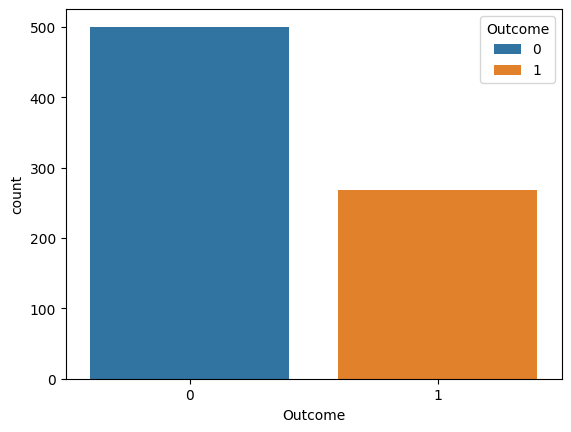

In [7]:
sns.countplot(x=dados['Outcome'], hue=dados['Outcome']);

In [32]:
X = dados.drop(columns=['Outcome'], axis=1)
y = dados[['Outcome']]

X.shape, y.shape

((768, 8), (768, 1))

In [33]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y) 

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((576, 8), (192, 8), (576, 1), (192, 1))

## **Validação Cruzada - Função Manual**

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Função de Validação Cruzada na MÃO
def validacao_cruzada(modelo, X, y, oversampling=False):
    # K-Fold do sckit-learn
    kfold = KFold(n_splits=10)
    
    # Lista de acuráricas de cada split
    acuracias_split = []
    
    # iterando sobre os splits
    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(X)):
        X_split_treino = X.iloc[idx_treino, :]
        y_split_treino = y.iloc[idx_treino, :]
        
        # oversampling somente no split de treino
        if oversampling:
            smote = SMOTE(random_state=42)
            X_split_treino, y_split_treino = smote.fit_resample(X_split_treino, y_split_treino)
            
        modelo.fit(X_split_treino, y_split_treino.values.flatten())
        
        X_split_validacao = X.iloc[idx_validacao, :]
        y_split_validacao = y.iloc[idx_validacao, :]
        
        # Validação SEM oversampling, da forma correta
        predicoes_validacao = modelo.predict(X_split_validacao)
        
        acuracia_split = accuracy_score(y_split_validacao, predicoes_validacao)
        acuracias_split.append(acuracia_split)
        
        print(f'Acurácia do split {idx}: {acuracia_split}')
        
    return acuracias_split

## **Criando o Modelo**

In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier
from statistics import mean

modelo_hgb = HistGradientBoostingClassifier()

media_acuracia_sem_smote = mean(validacao_cruzada(modelo_hgb, Xtrain, ytrain, oversampling=False)) * 100
media_acuracia_com_smote = mean(validacao_cruzada(modelo_hgb, Xtrain, ytrain, oversampling=True )) * 100

print(f'\nSem SMOTE: {media_acuracia_sem_smote:.02f}%   Com SMOTE: {media_acuracia_com_smote:.02f}%')

Acurácia do split 0: 0.7758620689655172
Acurácia do split 1: 0.7931034482758621
Acurácia do split 2: 0.7241379310344828
Acurácia do split 3: 0.6551724137931034
Acurácia do split 4: 0.7931034482758621
Acurácia do split 5: 0.7586206896551724
Acurácia do split 6: 0.6140350877192983
Acurácia do split 7: 0.7543859649122807
Acurácia do split 8: 0.8070175438596491
Acurácia do split 9: 0.6842105263157895
Acurácia do split 0: 0.7586206896551724
Acurácia do split 1: 0.7931034482758621
Acurácia do split 2: 0.7068965517241379
Acurácia do split 3: 0.6551724137931034
Acurácia do split 4: 0.7586206896551724
Acurácia do split 5: 0.6551724137931034
Acurácia do split 6: 0.631578947368421
Acurácia do split 7: 0.7719298245614035
Acurácia do split 8: 0.7192982456140351
Acurácia do split 9: 0.6666666666666666

Sem SMOTE: 73.60%   Com SMOTE: 71.17%


## **Forma ERRADA**

In [35]:
# Não se deve balancear as classes antes do split
from sklearn.model_selection import cross_val_score

# ERRADO !
smote = SMOTE(random_state=42)

Xtrain, ytrain = smote.fit_resample(Xtrain, ytrain)

# Os splits criados no cross_val_score estão com a validação BALANCEADA e isso
# é DISTORCER o mundo REAL
mean(cross_val_score(modelo_hgb, Xtrain, ytrain.values.flatten())) * 100

78.60870375547479